---
title: "8.2"
format: 
  html:
    theme: lux
---

# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
)
from plotnine import ggplot, aes, geom_line, geom_abline, labs, theme_minimal

# Load the Palmer Penguins dataset
penguins = pd.read_csv(
    "https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins.csv"
)

# Drop rows with missing values
penguins = penguins.dropna()

# Split the data into features and target
X = penguins.drop(columns=["species"])
y = penguins["species"]

# Dummify categorical variables
categorical_cols = X.select_dtypes(include=["object"]).columns
numerical_cols = X.select_dtypes(include=["float", "int"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(), categorical_cols),
    ]
)



Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

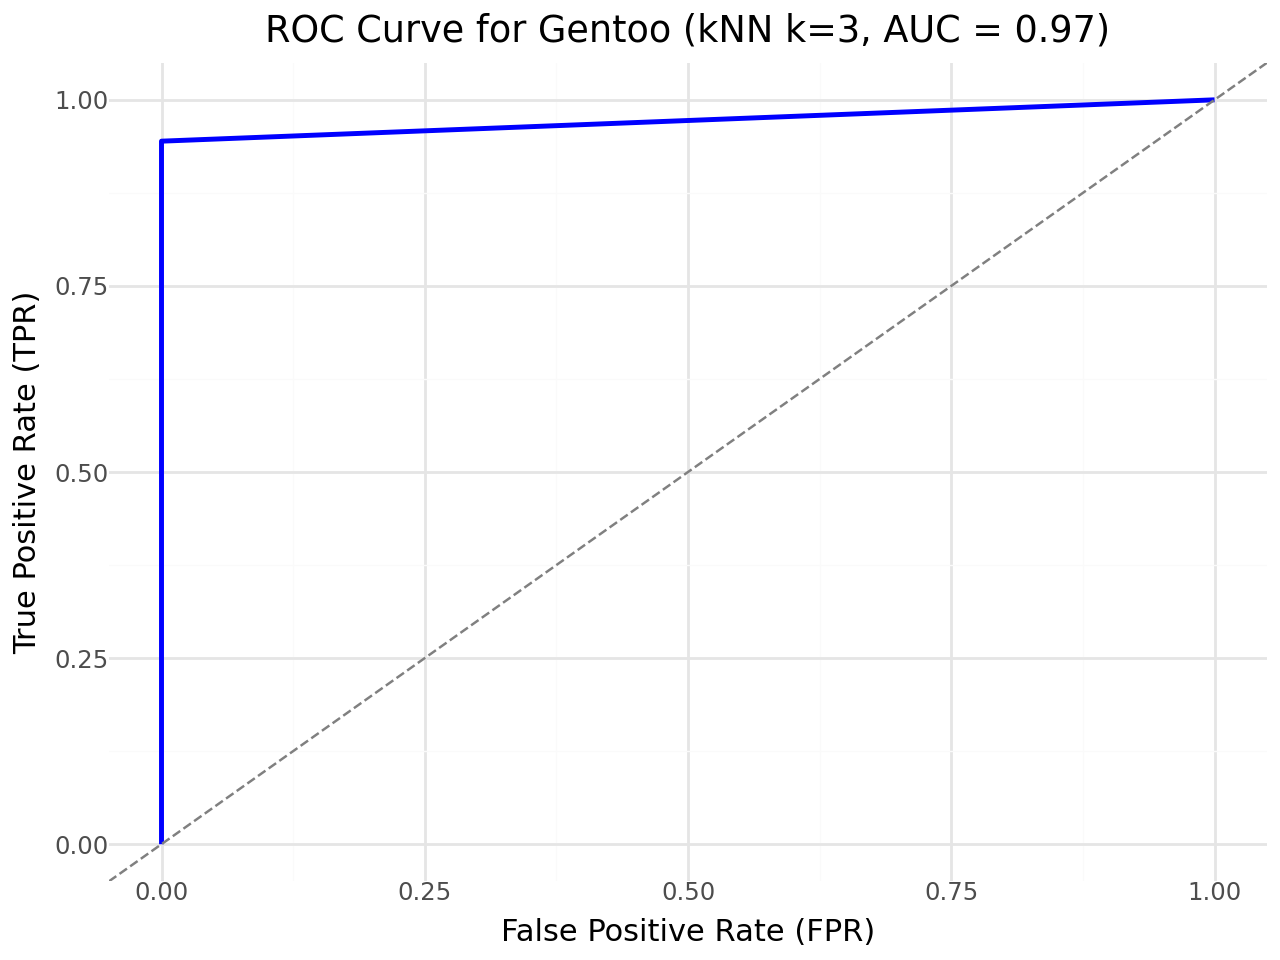

In [10]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Define models
models = {
    "kNN (k=3)": Pipeline([
        ("preprocessor", preprocessor),
        ("knn", KNeighborsClassifier(n_neighbors=3))
    ]),
    "kNN (k=7)": Pipeline([
        ("preprocessor", preprocessor),
        ("knn", KNeighborsClassifier(n_neighbors=7))
    ]),
    "Decision Tree (depth=3)": Pipeline([
        ("preprocessor", preprocessor),
        ("tree", DecisionTreeClassifier(max_depth=3, random_state=42))
    ]),
    "Decision Tree (depth=5)": Pipeline([
        ("preprocessor", preprocessor),
        ("tree", DecisionTreeClassifier(max_depth=5, random_state=42))
    ]),
}

# Train and evaluate models
results = []
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

# Calculate the probabilities for the "Gentoo" class
gentoo_binary_test = (y_test == "Gentoo").astype(int)
gentoo_class_index = np.where(model.classes_ == "Gentoo")[0][0]  # Ensure correct index
gentoo_pred_prob = y_pred_prob[:, gentoo_class_index]

# Compute FPR, TPR for ROC curve
fpr, tpr, thresholds = roc_curve(gentoo_binary_test, gentoo_pred_prob)
roc_auc = roc_auc_score(gentoo_binary_test, gentoo_pred_prob)

# Create the data frame for ROC plotting
roc_data = pd.DataFrame({"FPR": fpr, "TPR": tpr})

# Generate the plot
roc_plot = (
    ggplot(roc_data, aes(x="FPR", y="TPR")) +
    geom_line(color="blue", size=1) +  # The ROC curve
    geom_abline(intercept=0, slope=1, linetype="dashed", color="gray") +  # Random classifier line
    labs(
        title=f"ROC Curve for Gentoo (kNN k=3, AUC = {roc_auc:.2f})",
        x="False Positive Rate (FPR)",
        y="True Positive Rate (TPR)"
    ) +
    theme_minimal()
)

roc_plot




In [9]:
gentoo_binary_test = (y_test == "Gentoo").astype(int)
print("Binary labels for Gentoo (first 10):", gentoo_binary_test[:10])



FPR (first 10): [0. 0. 1.]
TPR (first 10): [0.         0.94444444 1.        ]
Thresholds (first 10): [inf  1.  0.]


In [4]:
# Print summary of model performance
print(f"Model: {model_name}")
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))


Model: Decision Tree (depth=5)
Accuracy: 0.9500
              precision    recall  f1-score   support

      Adelie       0.95      0.93      0.94        44
   Chinstrap       0.87      1.00      0.93        20
      Gentoo       1.00      0.94      0.97        36

    accuracy                           0.95       100
   macro avg       0.94      0.96      0.95       100
weighted avg       0.95      0.95      0.95       100

